## Imports and Defs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import random
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib.gridspec import GridSpec
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Define color codings

In [2]:
# Color coding for the 10%, optimal and wide regions
c10 = "teal"
cOpt = "darkorchid"
cWide = "coral"
regionColors = [c10, cOpt, cWide]

# Color coding for the functionals on the spectrum plots
pal = {'SOC-M06L':'#1f77b4','B97D3':'#ff7f0e','TPSS':'#2ca02c','M06L':'#d62728','PBE':'#9467bd',
      'B3LYP':'#1f77b4','CAM-B3LYP':'#ff7f0e','M06':'#2ca02c','M062X':'#d62728','$\\omega$-B97XD':'#9467bd','SOC-M06':'#ff7f0e', 'SOC-$\\omega$-B97XD':'#d62728',
      'B2PLYP':'#1f77b4', '$\\omega$-B2PLYP':'#2ca02c', 'SCS-PBE-QIDH':'#9467bd', 'B2GP-PLYP':'teal'}
func1 = ['TPSS', 'PBE', 'B97D3', 'M06L']
func1_b = ['TPSS', 'PBE', 'B97D3', 'M06L']
func2 = ['M06','M062X', 'B3LYP','CAM-B3LYP', '$\\omega$-B97XD']
func2_b = ['M06', 'SOC-M06L', 'M062X', 'B3LYP','CAM-B3LYP', '$\\omega$-B97XD', 'SOC-$\\omega$-B97XD']
func3 = ['B2PLYP', '$\\omega$-B2PLYP', 'SCS-PBE-QIDH', 'B2GP-PLYP']

Define some helper functions. Most are written for our [previous paper](https://doi.org/10.1002/cmtd.202200069) but we use the same methodology and they work here as well.

In [3]:
def get_percentages(errors, df_, group_by="functional"):
  # errors --> max_counts == df["size"], df_ --> actual_counts == df["counts"]
  max_counts = errors.groupby(group_by, as_index=False).size()
  df = df_.merge(max_counts, how="outer")
  df["percentage_count"] = df["counts"] / df["size"] * 100 # counts is from df_, size is from max_counts
  df.drop(columns=["size"], inplace=True)
  return df

def get_region(errors, region, group_by="functional", percentages=True):
  if region == "wide":
    rgn_ = errors.query("bandwidth > 0.35").copy()
  elif region in ("10%","tenpercent","ten_percent"):
    rgn_ = errors.query("(shift_factor <= 1.1) and (shift_factor >= 0.9)").copy()
  elif region in ("optimal","opt"):
    rgn_ = errors.query("(shift_factor < 1.2) and (shift_factor > 0.8) and (bandwidth < 0.30)").copy()
  elif region in ("above_10%","above_tenpercent","above_ten_percent"):
    rgn_ = errors.query("shift_factor > 1.1").copy()
  elif region in ("below_10%","below_tenpercent","below_ten_percent"):
    rgn_ = errors.query("shift_factor < 0.9").copy()
  else:
    return "Please provide a valid region!"
  rgn = rgn_.groupby(group_by, as_index=False).size()
  rgn.rename(columns={"size": "counts"}, inplace=True)
  if percentages == True:
    rgn = get_percentages(errors, rgn, group_by)
  else:
      for i in errors[group_by].unique():
        if i not in rgn[group_by].unique():
          rgn = pd.concat([rgn,pd.DataFrame({group_by:[i],"counts":0})], ignore_index=True)
  return rgn

def convert_error_names(errors):
    # errors['error_function'].replace({'mae': 'MAE', 'mse': 'MSE', 'rmsle': 'RMSLE', 'r_square': '$r^2$', 'R2': '$R^2$'},inplace=True)
    errors.replace({'error_function': {'mae': 'MAE', 'mse': 'MSE', 'rmsle': 'RMSLE', 'r_square': '$r^2$', 'R2': '$R^2$'}},inplace=True)

def get_errors_db(full_db):
  pred = full_db[full_db['reference'] == 'no']
  pred = pred.astype({'shift_factor': 'float64', 'bandwidth': 'float64', 'error_value':'float64'})
  errors = pred.get(["molecule","functional","error_value","bandwidth","shift_factor"]).drop_duplicates().reset_index(drop=True).copy()
  return errors # this is the database without the spectral data

def get_errors_db_isomers(full_db):
  pred = full_db[full_db['reference'] == 'no']
  pred = pred.astype({'shift_factor': 'float64', 'bandwidth': 'float64', 'error_value':'float64'})
  errors = pred.get(["molecule","functional","error_value","bandwidth","shift_factor","isomer"]).drop_duplicates().reset_index(drop=True).copy()
  return errors # this is the database without the spectral data

def get_fulldb(db_loc):
  if '.gz' in db_loc:
    df = pd.read_csv(db_loc, header=0, compression='gzip')
  if '.zip' in db_loc:
    df = pd.read_csv(db_loc, header=0, compression='zip')
  else:
    df = pd.read_csv(db_loc, header=0)
  df['functional'].replace({'STEOM-DLPNO-CCSD':'DLPNO-CCSD'},inplace=True)
  df['functional'].replace({'HF':'TDHF'},inplace=True)
  df['functional'].replace({'PBE-D3':'PBE'},inplace=True)
  df['functional'].replace({'B3LYP-D3':'B3LYP'},inplace=True)
  df['functional'].replace({'CAM-B3LYP-D3':'CAM-B3LYP'},inplace=True)
  df['functional'].replace({'def2-SVP':'$\\omega$-B2PLYP'},inplace=True) # misspelled wB2PLYP (wB2PYLP)
  df['molecule'].replace({'POZ_3':'POZ_2', 'PA_3':'PA_2'},inplace=True)
  df['molecule'].replace({'POZ_4':'POZ_3'},inplace=True)
  df['molecule'].replace({'POZ_5':'POZ_4'},inplace=True)
  return df

def get_lowestLambdas(fname):
  if fname[-4:] == '.csv':
    df = pd.read_csv(fname, header=0)
  elif fname[-4:] == '.xls' or fname[-4:] == 'xlsx':
    df = pd.read_excel(fname, header=0)
  df['functional'].replace({'STEOM-DLPNO-CCSD':'DLPNO-CCSD'},inplace=True)
  df['functional'].replace({'HF':'TDHF'},inplace=True)
  return df

def build_subset_generator_dict(df):
    molecules = df.molecule.unique()
    D = {}
    for mol in molecules:
        for i in ["Ir","Ru","Cu","Fe"]:
            if i in mol:
                D[mol] = i
                break
            else:
                D[mol] = "other"
    return D

def checkmols(fullset, subset):
    """
    For spectrum generation.
    """
    allOK = True
    for i in subset:
        if i not in fullset:
            print(f"{i} not found in fullset!")
            allOK = False
    if allOK == True:
        print("All files in the subset are in the fullset!")
        return 0
    else:
        return 1


Plot functions

In [4]:
def mse_fig(df, ordr, xlim=None, savename=''):
    """
    Horizontal barplot for the MSE results.
    """
    sns.reset_orig()
    scale=1.2
    sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                    scale,'xtick.major.width': scale,'ytick.major.width': scale})
    # errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
    g = sns.barplot(data=df, x="error_value", y="functional", color="darkcyan", order=ordr,
                    capsize=.4, errwidth=1.5) # .set(xlabel=f'MSE error', ylabel=None)
    g.set_xlabel('MSE error')
    g.set_ylabel(None)
    g.grid(axis = 'x')
    g.set_axisbelow(True)
    if xlim != None:
        g.set_xlim(0,xlim)
    sns.despine()
    plt.tight_layout()
    if savename != '':
        plt.savefig(savename, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

def hist2D(errors, ordr, savename, bar_lw=0.5, bbox_cols=3, bbox_pos=(1.0, 1.00)):
    """
    2D histogram with barplots below it that show the count percentages for each functional in the three regions.
    """
    wide_errors_functionals = get_region(errors, "wide", group_by="functional", percentages=True)
    optimal_functionals = get_region(errors, "optimal", group_by="functional", percentages=True)
    tenpercent_functionals = get_region(errors, "10%", group_by="functional", percentages=True)

    wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
    optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
    tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])

    # tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
    hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
    hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")

    sns.reset_orig()
    scale=1.2
    sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                    scale,'xtick.major.width': scale,'ytick.major.width': scale})

    # Set up the grid
    fig = plt.figure(figsize=(6,8))
    gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # ax1 -- 2D histogram
    sns.kdeplot(data=errors, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
    # sns.despine()
    ax1.set_ylim(0.01,0.55)
    ax1.set_xlim(0.514, 1.486)
    ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
    ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
    ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
    ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
    ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
    ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
    ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
    ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
    ax1.set_xlabel('scale factor')
    ax1.set_ylabel('bandwidth (eV)')

    # ax2 -- bar plot
    sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=ordr, edgecolor="white", linewidth=bar_lw)
    ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=bbox_pos, ncols=bbox_cols) #, bbox_to_anchor=(0.9, 1.))
    # loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
    #                                                  upper right (1.,1.) of the figure and shift along x by a little

    ax2.set_ylim(0,100)
    ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
    ax2.set_xlabel(None)
    ax2.grid(axis = 'y')
    ax2.set_axisbelow(True)

    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

    for item in ax2.get_xticklabels():
        item.set_rotation(90)

    # plt.tight_layout(pad=0.5)
    plt.savefig(savename, dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

def over_under(errors, ordr, savename):
    """
    Horizontal barplot that shows the under- and overestimation tendencies of the functionals.
    """
    above_10_percent = get_region(errors, "above_10%").drop(columns=["counts"]).rename(columns={"percentage_count":r'$\alpha$ > 1.1'})
    below_10_percent = get_region(errors, "below_10%").drop(columns=["counts"]).rename(columns={"percentage_count":r'$\alpha$ < 0.9'})
    # alphaText = r'0.9 $\leq$ $\alpha$ $\leq$ 1.1'
    alphaText = r'$\pm$10%'
    in10percent = get_region(errors, "10%").drop(columns=["counts"]).rename(columns={"percentage_count":alphaText})
    belabow_10_ = above_10_percent.merge(below_10_percent, how="outer").merge(in10percent, how="outer")

    sns.reset_orig()
    scale=1.2
    sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                    scale,'xtick.major.width': scale,'ytick.major.width': scale})

    palette = ['darkblue','slateblue','mediumseagreen']
    ax = belabow_10_.set_index("functional").loc[reversed(ordr)].plot(kind="barh",
                                                                            stacked=True, 
                                                                            y=[r'$\alpha$ > 1.1',r'$\alpha$ < 0.9',alphaText], 
                                                                            width=0.8, 
                                                                            color=palette)
    ax.set_aspect(5.75) # aspect ratio of the axes scaling, i.e. y/x-scale
    ax.set_axisbelow(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', pad=2., bottom=False, labelcolor='grey') # bring x ticklabels closer
    plt.legend([r'$\alpha$ > 1.1',r'$\alpha$ < 0.9',alphaText], 
            frameon=True, title=None, fontsize=12, facecolor="white", framealpha=1, 
            loc='upper center', bbox_to_anchor=(0.495, 1.1), ncol=3)
    plt.ylabel(None)
    plt.xlabel('count (%)', color='grey')
    plt.xlim(0,101)
    plt.grid(axis = 'x')
    # sns.despine()
    plt.savefig(savename, dpi=200, bbox_inches='tight', pad_inches=0.01)
    plt.show()
    plt.close()

def get_spectra(df, moleculesList=[]):
    """
    Plot the spectra for a randomly selected set of 3 molecules on a 3x3 grid.
    rows: molecules
    columns: functional types (pure, hybrid, double-hybrid)
    """
    sns.reset_orig()
    scale=1.2
    sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                    scale,'xtick.major.width': scale,'ytick.major.width': scale})

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
    if moleculesList == []:
        moleculesList = random.choices(df.molecule.unique(),k=3)
    # moleculesList = random.sample(sorted(fulldb[fulldb["molecule"].str.contains("Fe")].molecule.unique()),k=3)
    for i, mol in enumerate(moleculesList):
        molecule = df[df['molecule'] == mol]
        expt = molecule[molecule['reference'] == 'yes']
        mse_db1 = molecule[molecule['functional'].isin(func1)]
        mse_db2 = molecule[molecule['functional'].isin(func2)]
        mse_db3 = molecule[molecule['functional'].isin(func3)]

        sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

        sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

        sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

        # title = f"-------------------------- {mol} -------------------------------"
        title = mol
        ax[i][1].set_title(title, color="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
        ymax = 1.1*expt["Intensity [a.u.]"].max(numeric_only=True)
        ax[i][0].set_ylim(0,ymax)
        ax[i][0].set_xlim(200,700)

    plt.tight_layout()
    sns.despine()
    plt.show()
    plt.close()

def gen_spectra(dat, mols, funcs, savename=''):
    """
    Generates spectra where one row corresponds to one molecule and 
    the three columns in each row contain pure, hybrid and double hybrid functionals, respectively.

        - dat: the pandas database to analyze
        - mols: the list of molecules to plot
        - funcs: a nested three element list, where each element is a list of functionals, i.e., [[pure funcs],[hybrid funcs],[double hybrids]]
        - savename: optional filename to save the plot, if not defined the spectra will be plotted into the standard output
    """
    sns.reset_orig()
    scale=1.2
    sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                    scale,'xtick.major.width': scale,'ytick.major.width': scale})

    h = 4*len(mols)
    fig, ax = plt.subplots(nrows=len(mols), ncols=3, figsize=(14,h), sharex="row", sharey="row")
    #fig.subplots_adjust(hspace=0.3)

    for i, mol in enumerate(mols):
        # print(f"working on {mol}...")
        molecule = dat[dat['molecule'] == mol]
        expt = molecule[molecule['reference'] == 'yes']
        mse_db1 = molecule[molecule['functional'].isin(funcs[0])]
        mse_db2 = molecule[molecule['functional'].isin(funcs[1])]
        mse_db3 = molecule[molecule['functional'].isin(funcs[2])]

        sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=funcs[0]).legend(frameon=False,fontsize='12',ncol=1)

        sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=funcs[1]).legend(frameon=False,fontsize='12',ncol=1)

        sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
        sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=funcs[2]).legend(frameon=False,fontsize='12',ncol=1)

        # title = f"-------------------------- {mol} -------------------------------"
        title = mol
        ax[i][1].set_title(title, color="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
        # ymax = 1.1*expt["Intensity [a.u.]"].max(numeric_only=True)
        ymax = 1.1*expt.query("`Wavelength [nm]` >= 250")["Intensity [a.u.]"].max(numeric_only=True)
        ax[i][0].set_ylim(0,ymax)
        # ax[i][0].set_xlim(200,700)
        ax[i][0].set_xlim(250,700)

    plt.tight_layout()
    sns.despine()
    if savename != '':
        plt.savefig(savename, dpi=200, bbox_inches='tight', pad_inches=0.05)
    else:
        plt.show()
    plt.close()

## Set up initial databases

Load and merge the sub-databases

In [5]:
Ir_db = "_Ir_database_250nm.zip"
Ru_db = "_Ru_database_250nm.zip"
Fe_db = "_Fe_database_250nm.zip"
Cu_db = "_Cu_database_250nm.zip"
other_db = "_rest_of_metals_database_250nm.zip"
fulldb_list = [get_fulldb(i) for i in [Ir_db, Ru_db, Fe_db, Cu_db, other_db]]
fulldb = pd.concat(fulldb_list)
fulldb.drop(columns=["error_function"], inplace=True) # only have MSE as error function
expt = fulldb[fulldb['reference'] == 'yes']
expt = expt.drop(columns=["reference","functional","error_value","bandwidth","shift_factor"])

Uncomment the cell below to get the individual molecules and number of elements in each TMC subset.

In [6]:
# for i in [Ir_db, Ru_db, Fe_db, Cu_db, other_db]:
#     mls = get_fulldb(i).molecule.unique()
#     print(f"{len(mls)} molecules in subset:")
#     print(mls)

Uncomment the cells below to check the consistency of `fulldb`
> Note: these produce long outputs

In [7]:
# for fnc in fulldb.functional.unique():
#     print(f"shape of {fnc} data:")
#     print(fulldb.query("functional == @fnc").shape)

In [8]:
# for mol in fulldb.molecule.unique():
#     print(f"shape of {mol} data:")
#     print(fulldb.query("molecule == @mol").shape)

## Mean errors

In [9]:
errors = get_errors_db(fulldb)

In [10]:
errors["subset"] = errors["molecule"]
rep_dict = build_subset_generator_dict(errors)
errors["subset"].replace(rep_dict,inplace=True)

Define the ordering of functionals based on increasing MSE values:
- `mse_order`: All functionals including SOC variants and all subsets
- `mse_order_SOC`: All functionals including SOC variants but only for the Ru and Ir subsets (for which SOC calculations were done)
- `mse_order_noSOC`: All functionals without SOC and all subsets

In [11]:
mse_order = errors.groupby("functional",as_index=False).mean(numeric_only=True).sort_values(by="error_value",ignore_index=True).functional.unique()
mse_order_noSOC = []
for i in mse_order:
    if "SOC" not in i:
        mse_order_noSOC.append(i)

mse_order_SOC = errors[errors["molecule"].str.contains("Ir|Ru")].groupby("functional",as_index=False).mean(numeric_only=True).sort_values(by="error_value",ignore_index=True).functional.unique()
# print(mse_order)
# print(mse_order_SOC)
# print(mse_order_noSOC)

Test the number of entries for each functional. 

> **_NOTE:_** SOC is only calculated for the Ru and Ir somplexes so their results should not be compared with the global database.

In [12]:
# for i in mse_order:
#     print(i)
#     query_msg = f"functional == '{i}'"
#     # print(errors.query(query_msg).count().molecule)
#     print(errors.query(query_msg).count().molecule)

Generate figures (horizontal barplots) for MSE errors.

In [13]:
convert_error_names(errors) # 'mse' --> 'MSE'

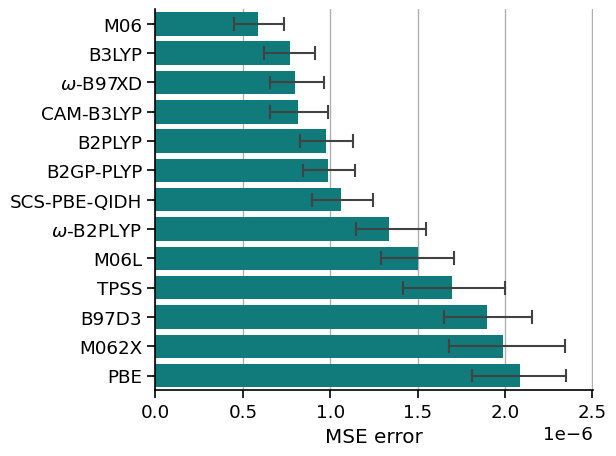

In [14]:
df_ = errors[~errors["functional"].str.contains("SOC")]
mse_fig(df_, mse_order_noSOC, 2.505e-6, 'errors_noSOC_.png')

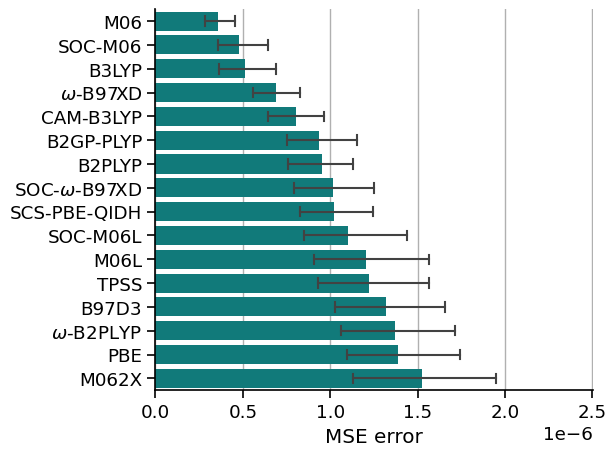

In [15]:
df_ = errors[errors["molecule"].str.contains("Ir|Ru")]
mse_fig(df_, mse_order_SOC, 2.505e-6, 'errors_SOC_.png')

## Alpha and delta distributions

In [16]:
errors = get_errors_db(fulldb)
# fulldb.equals(get_fulldb(db_loc)) # for testing

Calculate the MSE means and the corresponding standard errors (sem) for all functionals, then sort them by the means.

> Note: the values are multiplied by 10<sup>6</sup> for clarity

In [17]:
mseonly = errors.get(["functional","error_value"]).astype({'error_value': 'float64'}).copy()
mseonly["error_value"] = mseonly["error_value"] * 1e6
mse_means = mseonly.groupby("functional", as_index=False).mean().rename(columns={"error_value":"mse_mean"})
mse_sem = mseonly.groupby("functional", as_index=False).sem().rename(columns={"error_value":"mse_sem"}) # standard error of the mean
mse_means_ = mse_means.merge(mse_sem)
mse_means_['functional'] = pd.Categorical(mse_means_['functional'],categories=mse_order,ordered=True)
mse_means_ = mse_means_.sort_values(['functional'], ignore_index=True).round(2)

Now calculate the means and sems for the optimized bandwidths and scaling factors.

In [18]:
bw_means = errors.get(["functional","bandwidth"]).groupby("functional", as_index=False).mean().rename(columns={"bandwidth":"bandwidth_mean"})
bw_sem = errors.get(["functional","bandwidth"]).groupby("functional", as_index=False).sem().rename(columns={"bandwidth":"bandwidth_sem"}) # standard error of the mean
bw_means_ = bw_means.merge(bw_sem)
bw_means_['functional'] = pd.Categorical(bw_means_['functional'],categories=mse_order,ordered=True)
bw_means_ = bw_means_.sort_values(['functional'], ignore_index=True).round(2)

In [19]:
sf_means = errors.get(["functional","shift_factor"]).groupby("functional", as_index=False).mean().rename(columns={"shift_factor":"shift_factor_mean"})
sf_sem = errors.get(["functional","shift_factor"]).groupby("functional", as_index=False).sem().rename(columns={"shift_factor":"shift_factor_sem"}) # standard error of the mean
sf_means_ = sf_means.merge(sf_sem)
sf_means_['functional'] = pd.Categorical(sf_means_['functional'],categories=mse_order,ordered=True)
sf_means_ = sf_means_.sort_values(['functional'], ignore_index=True).round(2)

Tabulate the results in nice format and save the data to a csv file.

In [20]:
mse_means_['err_mean'] = mse_means_['mse_mean'].apply("{:.02f}".format) + ' (±' + mse_means_["mse_sem"].apply("{:.02f}".format) + ')'
bw_means_['bw_mean'] = bw_means_['bandwidth_mean'].apply("{:.02f}".format) + ' (±' + bw_means_["bandwidth_sem"].apply("{:.02f}".format) + ')'
sf_means_['sf_mean'] = sf_means_['shift_factor_mean'].apply("{:.02f}".format) + ' (±' + sf_means_["shift_factor_sem"].apply("{:.02f}".format) + ')'
mse_means_result = mse_means_.get(["functional","err_mean"]).merge(sf_means_.get(["functional","sf_mean"])).merge(bw_means_.get(["functional","bw_mean"]))
# err_mean is the MSE error x 1e6 !!!
mse_means_result.to_csv("mse_means_result.csv", index=False)
mse_means_result

,functional,err_mean,sf_mean,bw_mean
0,SOC-M06,0.48 (±0.07),0.99 (±0.01),0.24 (±0.01)
1,M06,0.58 (±0.07),0.97 (±0.01),0.27 (±0.01)
2,B3LYP,0.77 (±0.08),0.95 (±0.01),0.28 (±0.01)
3,$\omega$-B97XD,0.80 (±0.08),1.13 (±0.01),0.30 (±0.01)
4,CAM-B3LYP,0.81 (±0.08),1.13 (±0.01),0.29 (±0.01)
5,B2PLYP,0.97 (±0.08),0.93 (±0.01),0.29 (±0.01)
6,B2GP-PLYP,0.99 (±0.08),1.00 (±0.01),0.30 (±0.01)
7,SOC-$\omega$-B97XD,1.02 (±0.12),1.16 (±0.01),0.31 (±0.02)
8,SCS-PBE-QIDH,1.06 (±0.09),1.02 (±0.01),0.32 (±0.01)
9,SOC-M06L,1.10 (±0.16),0.88 (±0.01),0.26 (±0.01)


### Generate wordcloud for TOC figure

Generate frequencies based on the number of hits in the ±10% region:

In [21]:
soc_exclude = ['SOC-$\\omega$-B97XD', 'SOC-M06', 'SOC-M06L']
FuncNameFreqs_ = get_region(errors.query("functional not in @soc_exclude"), "10%", group_by="functional").drop(columns=["counts"]).fillna(1.)
funcs = list(FuncNameFreqs_["functional"].replace({"$\\omega$-B2PLYP": "ω-B2PLYP", "$\\omega$-B97XD": "ω-B97XD"}))
cnts = list(FuncNameFreqs_["percentage_count"])
FuncNameFreqs = dict(zip(funcs, cnts))
FuncNameFreqs

{'ω-B2PLYP': 28.05755395683453,
 'ω-B97XD': 25.899280575539567,
 'B2GP-PLYP': 53.956834532374096,
 'B2PLYP': 43.884892086330936,
 'B3LYP': 58.992805755395686,
 'B97D3': 32.37410071942446,
 'CAM-B3LYP': 25.179856115107913,
 'M06': 82.01438848920863,
 'M062X': 22.302158273381295,
 'M06L': 41.007194244604314,
 'PBE': 25.899280575539567,
 'SCS-PBE-QIDH': 49.64028776978417,
 'TPSS': 30.215827338129497}

Create the raw mask for the wordcloud. It needs to be edited in Paint before use in the next step. The edited image `_spectrum_mask_done.png` is uploaded.

In [22]:
toplot = fulldb.query("molecule == 'Ru-bpy'").query("reference == 'yes'")
sns.lineplot(x="Wavelength [nm]", y="Intensity [a.u.]", data=toplot, color="black")
plt.xlim([265,550])
plt.tight_layout()
sns.despine()
plt.xticks([])
plt.yticks([])
# plt.show()
plt.savefig('spectrum_mask_raw.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.close()

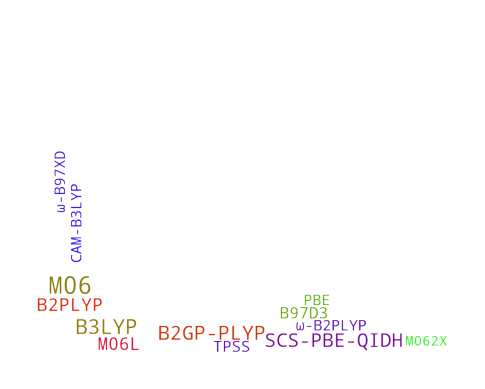

In [23]:
mask = np.array(Image.open('_spectrum_mask_done.png'))

wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", random_state=42, mask=mask, max_font_size=55, colormap="brg").generate_from_frequencies(FuncNameFreqs)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file(filename='TOC_cloud.png')
# #plt.savefig('TOC_WC.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.close()

### 2D histograms and over/underestimation

Plot the 2D histogram (with kernel density estimation for smoothing) of the distribution of the bandwidth and scale factor parameters using the MSE data. 
- We use with kernel density estimation for smoothing and contour lines for visualization. 
- We also set up three regions (10%, optimal, wide) and count the number of occurrences of each functional in these regions.

In [24]:
errors = get_errors_db(fulldb[~fulldb["functional"].str.contains("SOC")])

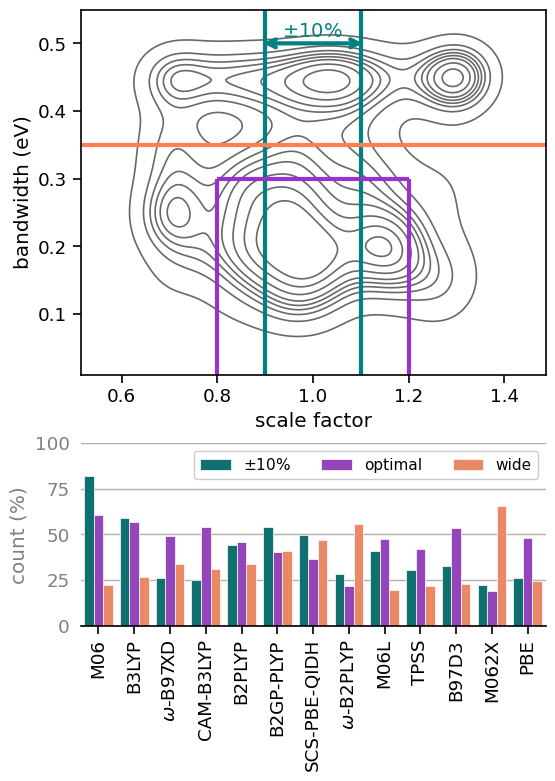

In [25]:
hist2D(errors, mse_order_noSOC, '2D_hist_noSOC_.png', bar_lw=0.5)

Plot the over- and underestimation tendency for each functional based on the value of the optimized scale factor parameter. The 10% region is considered "perfect" and occurrences of functionals above and below (in terms of scale factor) this region are collected.

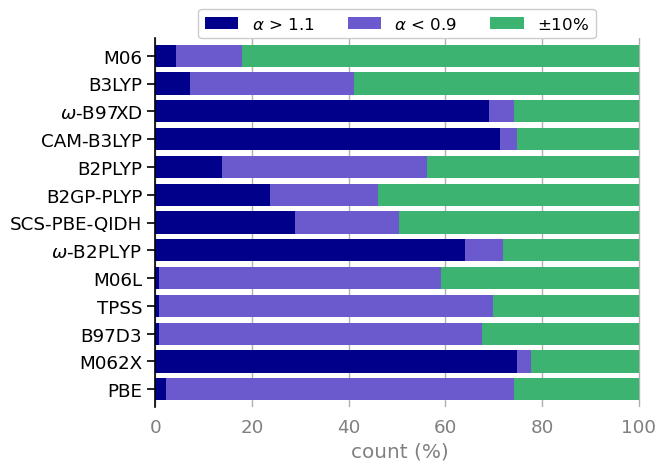

In [26]:
over_under(errors, mse_order_noSOC, 'over_under_alpha_noSOC_.png')

Now do the same steps for the SOC data and Ir/Ru subsets

In [27]:
errors = get_errors_db(fulldb[fulldb["molecule"].str.contains("Ir|Ru")])

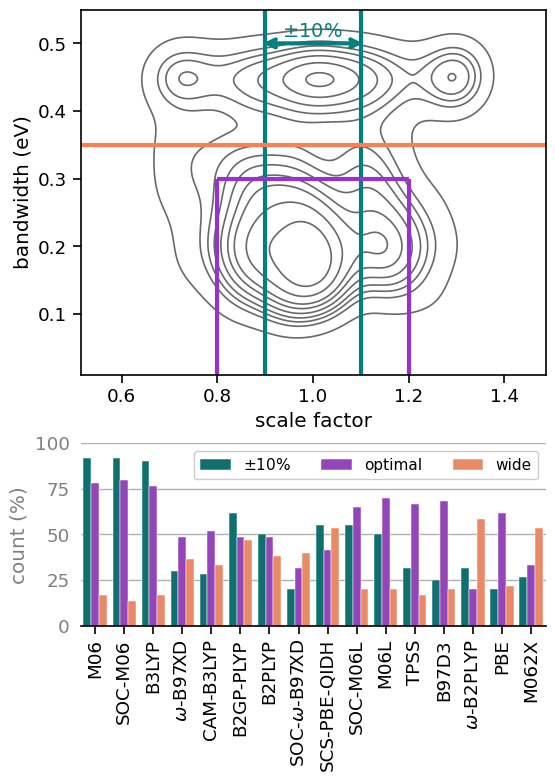

In [28]:
hist2D(errors, mse_order_SOC, '2D_hist_SOC_.png', bar_lw=0.35)

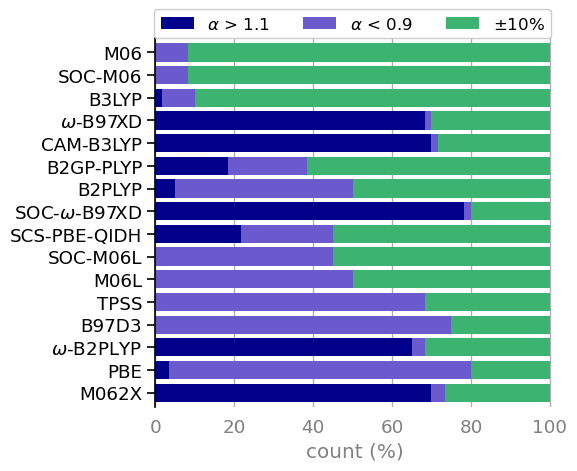

In [29]:
over_under(errors, mse_order_SOC, 'over_under_alpha_SOC_.png')

Check the Fe subset, which is problematic for most functionals

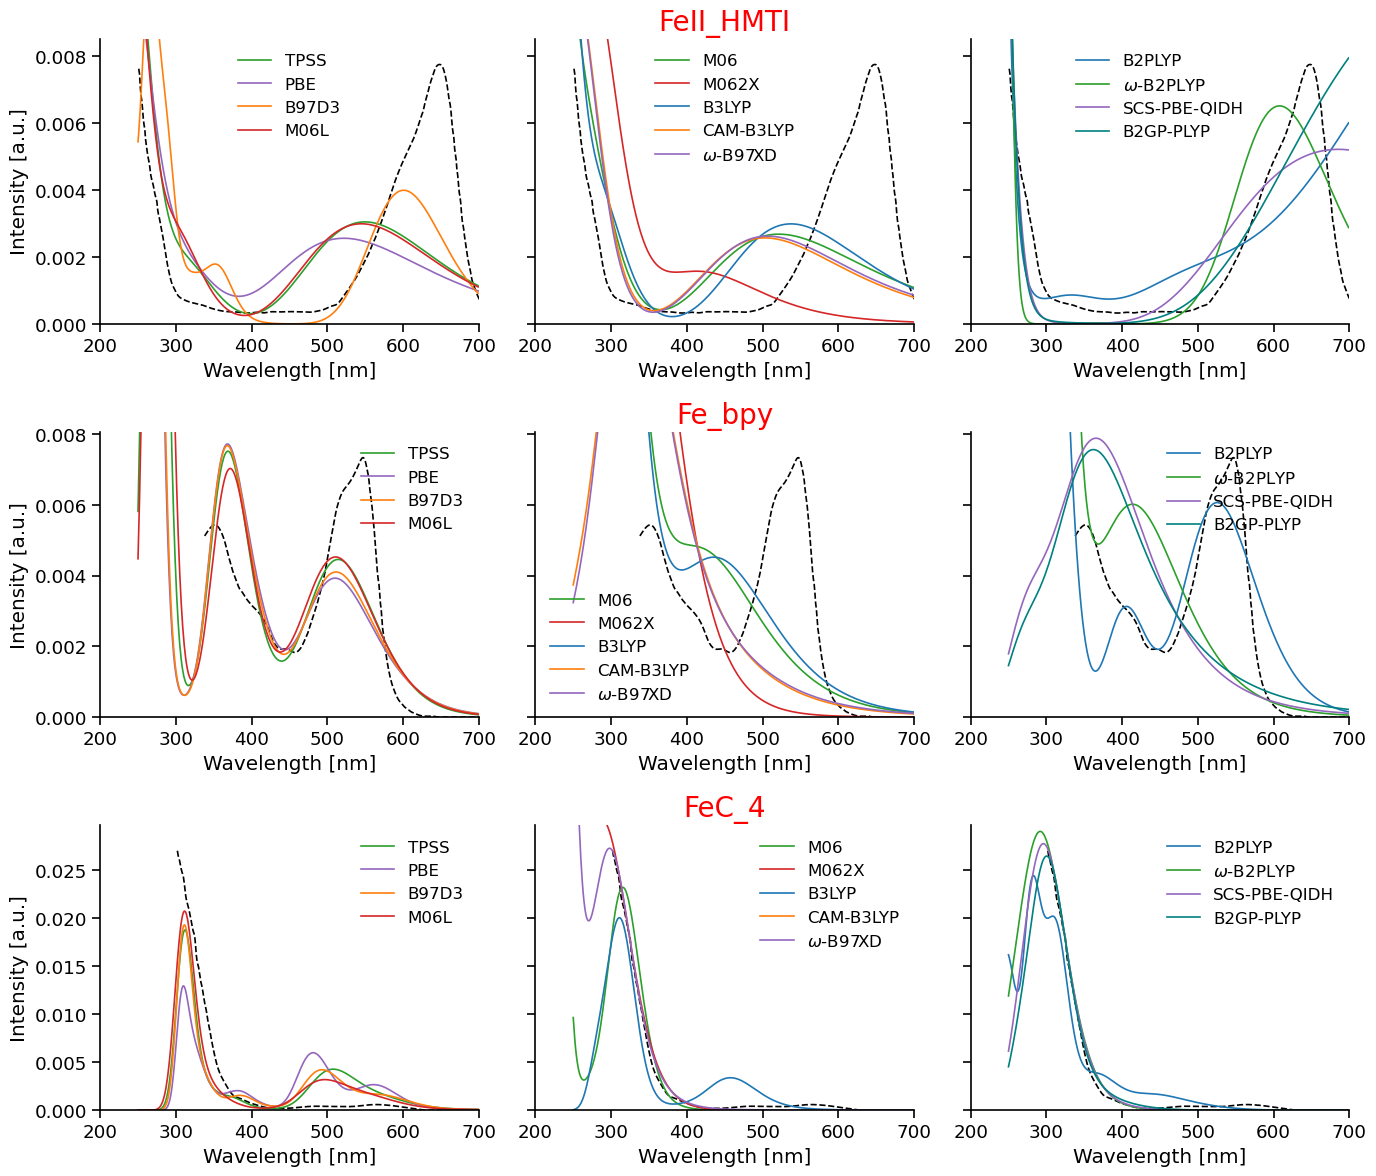

In [30]:
irons = sorted(fulldb[fulldb["molecule"].str.contains("Fe")].molecule.unique())
df_ = fulldb.query("molecule in @irons")
get_spectra(df_)

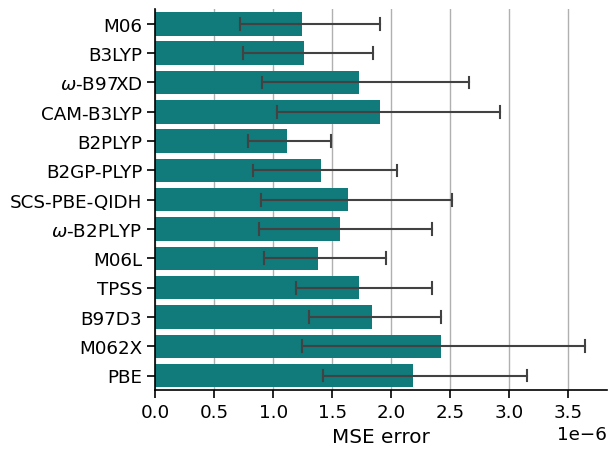

In [31]:
df_ = get_errors_db(fulldb[fulldb["molecule"].str.contains("Fe")])
mse_fig(df_, mse_order_noSOC, None, 'errors_Fe_.png')

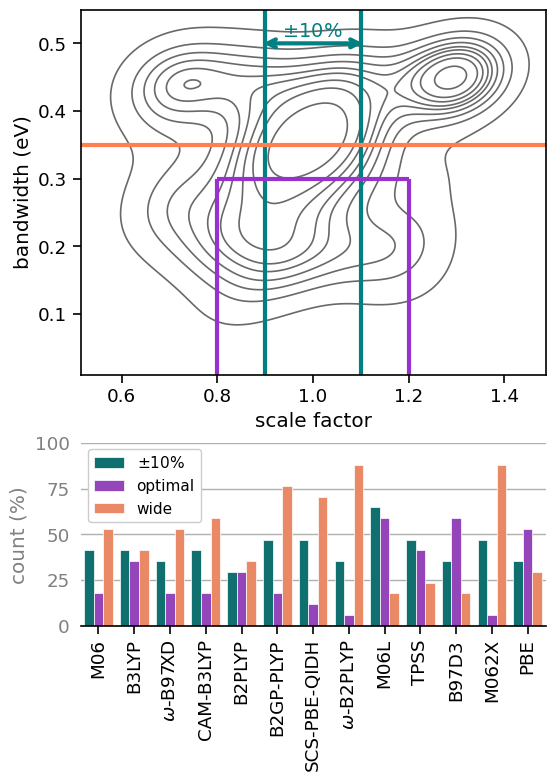

In [32]:
hist2D(df_, mse_order_noSOC, '2D_hist_Fe_.png', bar_lw=0.5, bbox_cols=1, bbox_pos=(0.275, 1.01))

## Spectra

Save all spectra into image (png) files:
- every file contains a maximum of 5 TMCs (subplot rows) so the png will nicely fit the A4 pages of the Supporting Information
- for every TMC there are 3 spectra (subplot columns) to separate pure, hybrid and double-hybrid functionals
- SOC data are not included for clarity as in most cases the fitted spectra are identical to that of the non-SOC variant

### Ru subset

In [33]:
def make_ru_spectra(full_db=fulldb):
    ru_set = full_db[full_db["molecule"].str.contains("Ru")]

    ru_mols_1 = ['Ru-NHC_1', 'Ru-NHC_2', 'Ru-NHC_3', 'Ru-NHC_4', 'Ru-NHC_5']
    ru_mols_2 = ['Ru-qd_1', 'Ru-qd_2', 'Ru-qd_3', 'Ru-qd_4']
    ru_mols_3 = ['Ru-CN_1', 'Ru-CN_2', 'Ru-CN_3', 'Ru-CN_4']
    ru_mols_4 = ['Ru-bpz', 'Ru-bpz-bpy_12', 'Ru-bpz-bpy_21']
    ru_mols_5 = ['Ru-arylbpy_1', 'Ru-arylbpy_2', 'Ru-arylbpy_3']
    ru_mols_6 = ['Ru-PRC_1', 'Ru-PRC_2']
    ru_mols_7 = ['Ru-bpy-NN_2', 'Ru-bpy-NN_3', 'Ru-bpy-NN_4', 'Ru-bpy-NN_5', 'Ru-bpy-NN_6']
    ru_mols_8 = ['Ru-bpy', 'Ru-bpy-dppz', 'Ru-bpy-dpq', 'Ru-bpy-phen', 'Ru-bpm']
    
    sumsubsets = [*ru_mols_2, *ru_mols_1, *ru_mols_3, *ru_mols_4, *ru_mols_5, *ru_mols_6, *ru_mols_7, *ru_mols_8]
    checkmols(ru_set.molecule.unique(), sumsubsets)
    checkmols(sumsubsets, ru_set.molecule.unique())
    
    gen_spectra(ru_set, sumsubsets[:4], funcs=[func1,func2, func3], savename="Ru_1.png") # 4 rows
    for n, i in enumerate(range(4,len(sumsubsets),5)): # 5 rows
        gen_spectra(ru_set, sumsubsets[i:i+5], funcs=[func1, func2, func3], savename=f"Ru_{n+2}.png")
        # print(f"Ru_{n+2}.png has been created!")

> messages from the cell below are consistency checks

In [34]:
make_ru_spectra(fulldb)

All files in the subset are in the fullset!
All files in the subset are in the fullset!


In [35]:
plt.close() # for safety, run in case of error in the line above

### Ir subset

In [36]:
def make_ir_spectra(full_db=fulldb):
    ir_set = full_db[full_db["molecule"].str.contains("Ir")]

    ir_mols_1 = ['Ir_isoCN_1', 'Ir_isoCN_2', 'Ir_isoCN_3', 'Ir_isoCN_4', 'Ir_isoCN_5', 'Ir_isoCN_6', 'Ir_isoCN_7']
    ir_mols_2 = ['Ir_isoCN-acac_1', 'Ir_isoCN-acac_2', 'Ir_isoCN-acac_3']
    ir_mols_3 = ['Ir-he_1', 'Ir-he_2', 'Ir-he_3', 'Ir-he_4', 'Ir-he_5', 'Ir-he_6']
    ir_mols_4 = ['Ir-ho_1', 'Ir-ho_2', 'Ir-ho_3', 'Ir-ho_4', 'Ir-ho_5', 'Ir-ho_6']
    ir_mols_5 = ['Ir_CNC_3', 'Ir_CNC_4', 'Ir_CNC_6']
    ir_mols_6 = ['IrIII_encaps_5', 'IrIII_encaps_6']
    ir_mols_7 = ['Ir-ppy-bpy_1', 'Ir-ppy-bpy_2']

    sumsubsets = [*ir_mols_1, *ir_mols_2, *ir_mols_3, *ir_mols_4, *ir_mols_5, *ir_mols_6, *ir_mols_7]
    checkmols(ir_set.molecule.unique(), sumsubsets)
    checkmols(sumsubsets, ir_set.molecule.unique())

    gen_spectra(ir_set, sumsubsets[:4], funcs=[func1, func2, func3], savename="Ir_1.png")
    gen_spectra(ir_set, sumsubsets[4:9], funcs=[func1, func2, func3], savename="Ir_2.png")
    gen_spectra(ir_set, sumsubsets[9:14], funcs=[func1, func2, func3], savename="Ir_3.png")
    gen_spectra(ir_set, sumsubsets[14:19], funcs=[func1, func2, func3], savename="Ir_4.png")
    gen_spectra(ir_set, sumsubsets[19:24], funcs=[func1, func2, func3], savename="Ir_5.png")
    gen_spectra(ir_set, sumsubsets[24:], funcs=[func1, func2, func3], savename="Ir_6.png")

> messages from the cell below are consistency checks

In [37]:
make_ir_spectra(fulldb)

All files in the subset are in the fullset!
All files in the subset are in the fullset!


In [38]:
plt.close() # for safety, run in case of error in the line above

### Fe subset

In [39]:
def make_fe_spectra(full_db=fulldb):
    fe_set = full_db[full_db["molecule"].str.contains("Fe")]
    # fe_set.molecule.unique()

    fe_mols_1 = ['FeII_CNC_1', 'FeII_CNC_2']
    fe_mols_2 = ['FeII_carbene_C2', 'FeII_carbene_C3', 'FeII_carbene_C4']
    fe_mols_3 = ['FeC_1', 'FeC_2', 'FeC_3', 'FeC_4', 'FeC_5', 'FeC_6', 'FeC_7']
    fe_mols_4 = ['Fe_bpy', 'Fe_dcpp', 'Fe_tpy']
    fe_mols_5 = ['FeTP', 'FeII_HMTI']

    sumsubsets = [*fe_mols_3, *fe_mols_1, *fe_mols_2, *fe_mols_4, *fe_mols_5]
    checkmols(fe_set.molecule.unique(), sumsubsets)
    checkmols(sumsubsets, fe_set.molecule.unique())

    gen_spectra(fe_set, sumsubsets[:4], funcs=[func1,func2, func3], savename="Fe_1.png")
    gen_spectra(fe_set, sumsubsets[4:9], funcs=[func1,func2, func3], savename="Fe_2.png")
    gen_spectra(fe_set, sumsubsets[9:14], funcs=[func1,func2, func3], savename="Fe_3.png")
    gen_spectra(fe_set, sumsubsets[14:], funcs=[func1,func2, func3], savename="Fe_4.png")

> messages from the cell below are consistency checks

In [40]:
make_fe_spectra(fulldb)

All files in the subset are in the fullset!
All files in the subset are in the fullset!


In [41]:
plt.close() # for safety, run in case of error in the line above

### Cu subset

In [42]:
def make_cu_spectra(full_db=fulldb):
    cu_set = full_db[full_db["molecule"].str.contains("Cu")]
    # cu_set.molecule.unique()

    cu_mols_1 = ['CuBCz', 'CuPhCz']
    cu_mols_2 = ['Cu-phen_1', 'Cu-phen_2', 'Cu-phen_3']
    cu_mols_3 = ['Cu-xant-dmp', 'Cu-xant-dppz', 'Cu-xant-dpq']
    cu_mols_4 = ['Cu50_phen2', 'Cu50_dq2', 'Cu50_tmp2', 'Cu50_batho2', 'Cu50_dmp2']
    cu_mols_5 = ['Cu50_BINAP_quintri', 'Cu50_BINAP_iquintri', 'Cu50_BINAP_tmp', 'Cu50_BINAP_dq', 'Cu50_BINAP_dmp', 
                'Cu50_BINAP_dtbbp', 'Cu50_BINAP_batho', 'Cu50_BINAP_phen', 'Cu50_BINAP_dmbp', 'Cu50_BINAP_pytri']
    cu_mols_6 = ['Cu50_DPEPhos-quintri', 'Cu50_DPEPhos-iquintri', 'Cu50_DPEPhos-tmp', 'Cu50_DPEPhos-dq', 'Cu50_DPEPhos-dmp', 
                'Cu50_DPEPhos-dtbbp', 'Cu50_DPEPhos-batho', 'Cu50_DPEPhos-phen', 'Cu50_DPEPhos-dmbp', 'Cu50_DPEPhos-pytri']
    cu_mols_7 = ['Cu50_XantPhos-quintri', 'Cu50_XantPhos-iquintri', 'Cu50_XantPhos-tmp', 'Cu50_XantPhos-dq', 'Cu50_XantPhos-dmp', 
                'Cu50_XantPhos-dtbbp', 'Cu50_XantPhos-batho', 'Cu50_XantPhos-phen', 'Cu50_XantPhos-dmbp', 'Cu50_XantPhos-pytri']
    cu_mols_8 = ['Cu50_dppf-quintri', 'Cu50_dppf-iquintri', 'Cu50_dppf-tmp', 'Cu50_dppf-dq', 'Cu50_dppf-dmp', 
                'Cu50_dppf-dtbbp', 'Cu50_dppf-batho', 'Cu50_dppf-phen', 'Cu50_dppf-dmbp', 'Cu50_dppf-pytri']
    
    sumsubsets = [*cu_mols_1, *cu_mols_2, *cu_mols_3, *cu_mols_4, *cu_mols_5, *cu_mols_6, *cu_mols_7, *cu_mols_8]
    checkmols(cu_set.molecule.unique(), sumsubsets)
    checkmols(sumsubsets, cu_set.molecule.unique())

    gen_spectra(cu_set, sumsubsets[:4], funcs=[func1,func2, func3], savename="Cu_1.png")
    for n, i in enumerate(range(4,len(sumsubsets),5)):
        try:
            gen_spectra(cu_set, sumsubsets[i:i+5], funcs=[func1,func2, func3], savename=f"Cu_{n+2}.png")
        except IndexError:
            gen_spectra(cu_set, sumsubsets[i:i+5], funcs=[func1,func2, func3], savename=f"Cu_{n+2}.png")


> messages from the cell below are consistency checks

In [43]:
make_cu_spectra(fulldb)

All files in the subset are in the fullset!
All files in the subset are in the fullset!


In [44]:
plt.close() # for safety, run in case of error in the line above

### other subset

In [45]:
def make_other_spectra(full_db=fulldb):
    other_set = full_db[~full_db["molecule"].str.contains("Ru|Ir|Cu|Fe")]
    # other_set.molecule.unique()

    other_mols_1 = ['Au-alkyne_1', 'Au-alkyne_2', 'Au-alkyne_3', 'AuBCz']
    other_mols_2 = ['Mo0_carbonyl_1', 'Mo0_carbonyl_2', 'Mo-CN_1']
    other_mols_3 = ['W-CN_1', 'W-CN_3']

    sumsubsets = [*other_mols_1, *other_mols_2, *other_mols_3]
    checkmols(other_set.molecule.unique(), sumsubsets)
    checkmols(sumsubsets, other_set.molecule.unique())

    gen_spectra(other_set, sumsubsets[:4], funcs=[func1, func2, func3], savename="Au.png")
    gen_spectra(other_set, sumsubsets[4:], funcs=[func1, func2, func3], savename="Mo_W.png")

> messages from the cell below are consistency checks

In [46]:
make_other_spectra(fulldb)

All files in the subset are in the fullset!
All files in the subset are in the fullset!


In [47]:
plt.close() # for safety, run in case of error in the line above

## Distributions for metals

In [48]:
errors = get_errors_db(fulldb)
errors["subset"] = errors["molecule"]
rep_dict = build_subset_generator_dict(errors)
errors["subset"].replace(rep_dict,inplace=True)

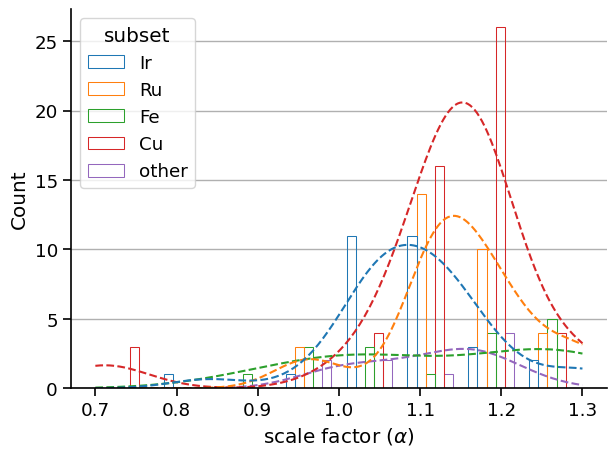

In [49]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = sns.color_palette("tab10")
# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=errors.query("functional == 'CAM-B3LYP'"), x="shift_factor", hue="subset", multiple="dodge", 
                 shrink=.75, kde=True, binwidth=0.075, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
# g = sns.histplot(data=errors, x="shift_factor", hue="subset", multiple="dodge", shrink=.8, kde=True)
g.set_xlabel(r'scale factor ($\alpha$)')
# g.set_ylabel(None)
# g.set_ylim(0,18)
g.grid(axis = 'y')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('shift_distribution_CAM-B3LYP.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

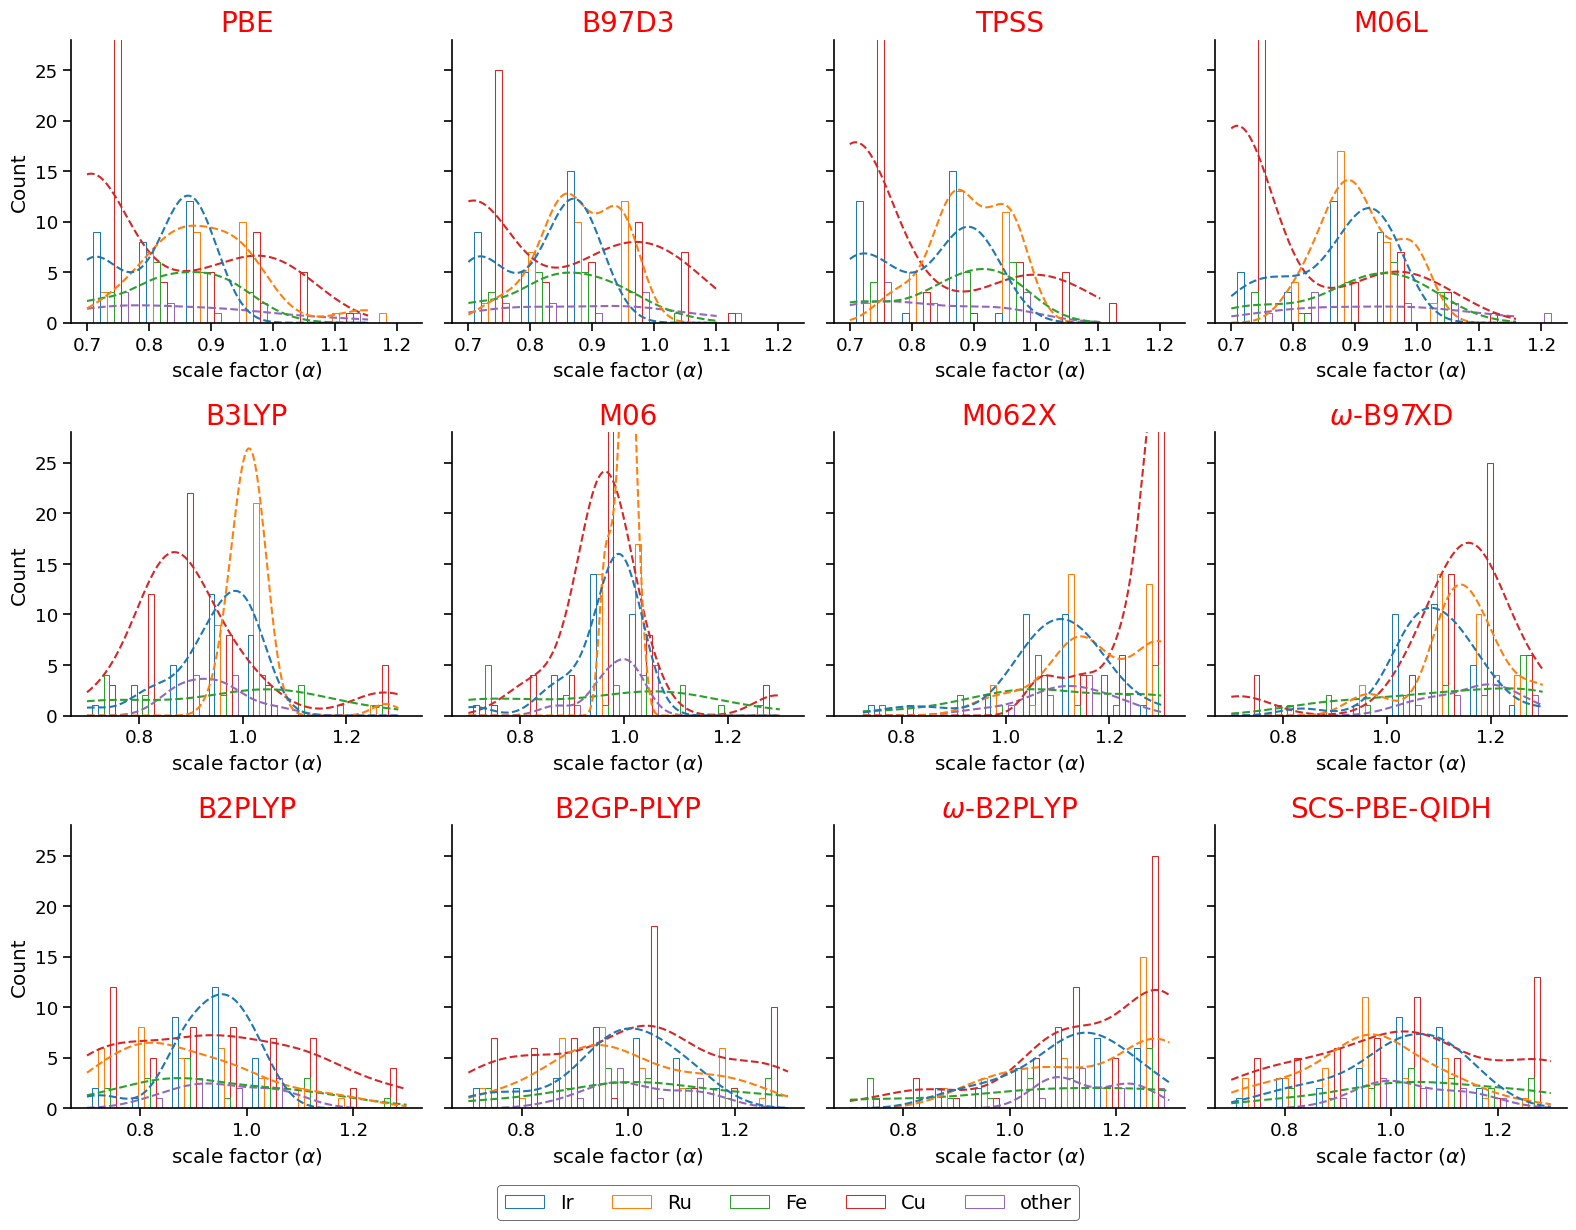

In [50]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16,12), sharex="row", sharey="row")
flataxes = ax.flatten()
#fig.subplots_adjust(hspace=0.3)

# set up the list of functionals that fits in the 3x4 plot

# functionals = []
# for fnc in fulldb.functional.unique():
#   if ("SOC" not in fnc) and ("CAM-B3LYP" not in fnc) and ("expt" not in fnc):
#     functionals.append(fnc)

functionals = ['PBE','B97D3','TPSS','M06L',
               'B3LYP','M06','M062X','$\\omega$-B97XD',
               'B2PLYP','B2GP-PLYP','$\\omega$-B2PLYP','SCS-PBE-QIDH']

palette = sns.color_palette("tab10")

for i, funct in enumerate(functionals):
  subdb_fnc = errors.query("functional == @funct")
  sns.histplot(ax=flataxes[i], data=subdb_fnc, x="shift_factor", hue="subset", multiple="dodge", 
               shrink=.75, kde=True, binwidth=0.075, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
  # title = f"-------------------------- {mol} -------------------------------"
  title = funct
  flataxes[i].set_title(title, color="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')

# handles, labels = flataxes[0].get_legend_handles_labels()
# print(handles)
# print(labels)
# fig.legend(handles=flataxes[0].get_legend().legendHandles, labels=['Ir','Ru','Fe','Cu','other'], loc='lower center', frameon=True)
handles = flataxes[0].get_legend().legendHandles
labels = [i._text for i in flataxes[0].get_legend().texts]
legend = fig.legend(handles=handles, labels=labels, loc='lower center', frameon=True, ncols=len(labels), 
                    fontsize=14, bbox_to_anchor=(0.5, -0.035), edgecolor="k")
legend.get_frame().set_linewidth(0.5)
for i in flataxes:
  i.get_legend().remove()
  i.set_ylim(0,28)
  i.yaxis.set_ticks(np.arange(0, 27, 5))
  i.set_xlabel(r'scale factor ($\alpha$)')

plt.tight_layout()
sns.despine()
plt.savefig('3x4_shiftfactor_distribution.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [51]:
errors.query("functional == 'M06'").query("subset == 'Ir'").query("shift_factor < 0.9")

,molecule,functional,error_value,bandwidth,shift_factor,subset
48,Ir-ho_2,M06,4.570667e-07,0.366470,0.709587,Ir
178,Ir-he_4,M06,2.861069e-07,0.405163,0.889255,Ir
263,Ir_CNC_3,M06,1.144781e-07,0.449999,0.857942,Ir
336,Ir_isoCN_3,M06,2.007877e-06,0.311008,0.895290,Ir
410,Ir_isoCN_7,M06,1.783972e-07,0.449997,0.850104,Ir


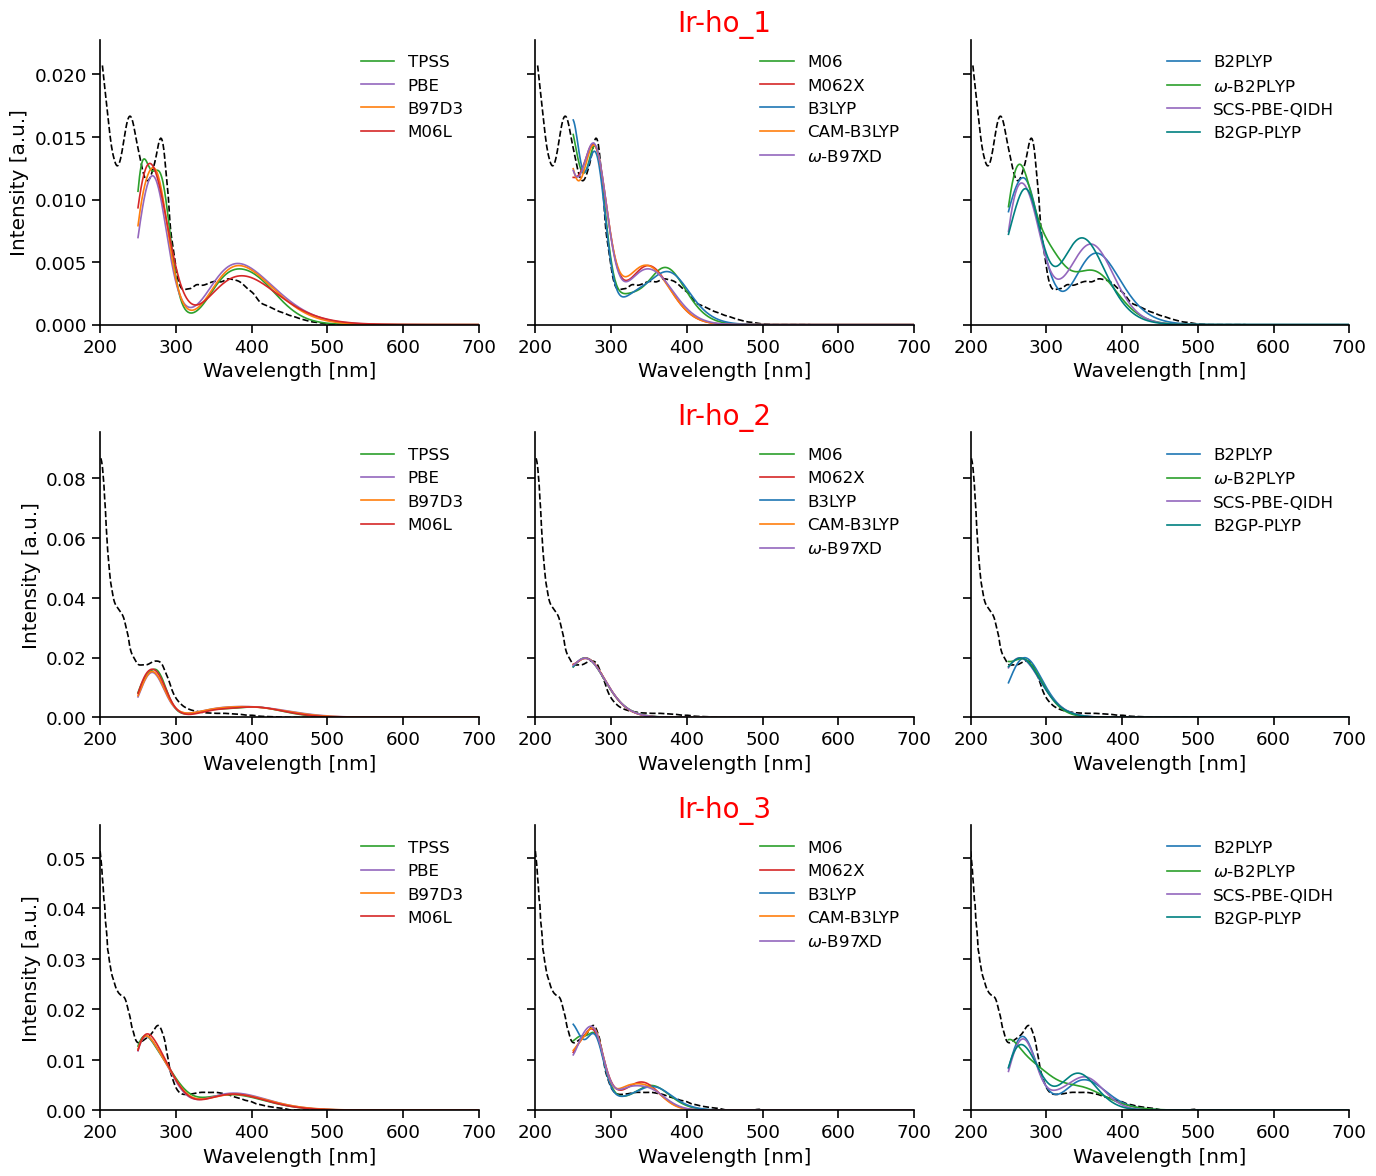

In [52]:
get_spectra(fulldb, ["Ir-ho_1","Ir-ho_2","Ir-ho_3"])

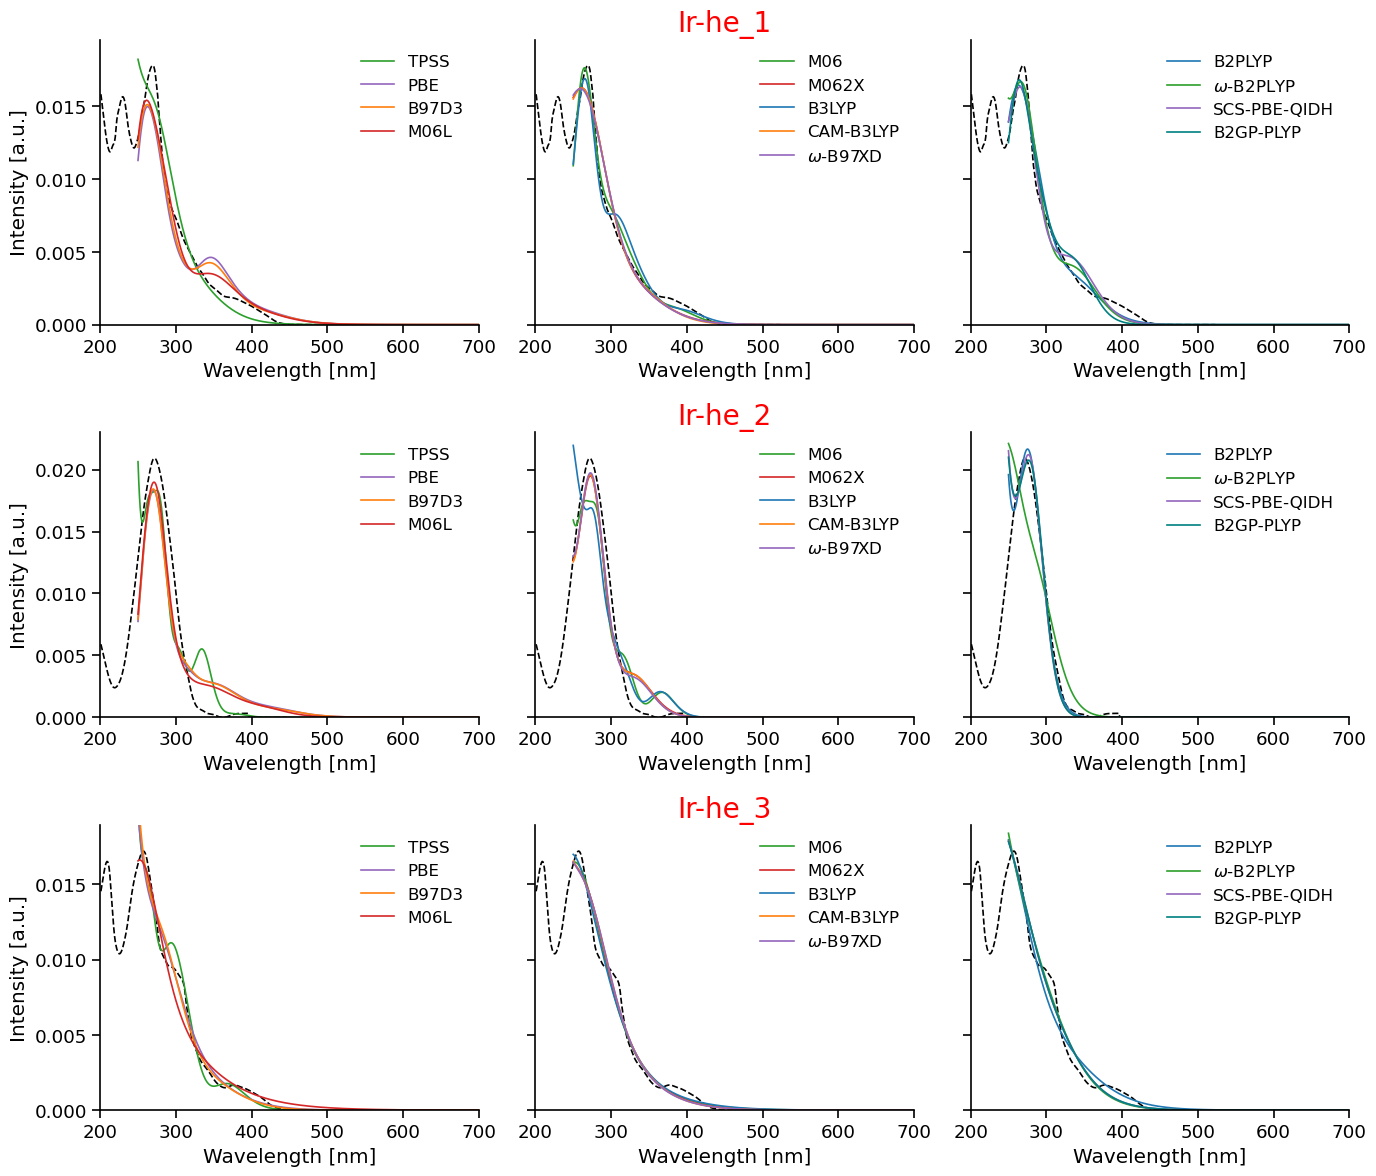

In [53]:
get_spectra(fulldb, ["Ir-he_1","Ir-he_2","Ir-he_3"])

### Pure hybrids and the Cu subset

In [54]:
cuset = errors.query("functional == 'M06'").query("subset == 'Cu'").copy()
molecules = cuset.molecule.unique()
D = {}
for mol in molecules:
    for i in ["BINAP","DPEPhos","XantPhos","dppf"]:
        if i in mol:
            D[mol] = i
            break
        else:
            D[mol] = "other"

G = {}
for mol in molecules:
    for i in ["iquintri","quintri","tmp","dq","dmp","dtbbp","batho","phen","dmbp"]:
        if i in mol:
            G[mol] = i
            break
        else:
            G[mol] = "other"

In [55]:
cuset["phosphine"] = cuset["molecule"]
rep_dict_ = D
cuset["phosphine"].replace(rep_dict_,inplace=True)
cuset["amine"] = cuset["molecule"]
rep_dict_ = G
cuset["amine"].replace(rep_dict_,inplace=True)

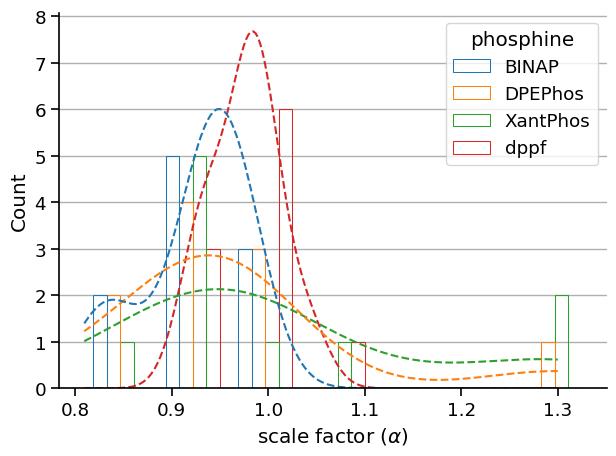

In [56]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = sns.color_palette("tab10")
# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=cuset.query("phosphine != 'other'"), x="shift_factor", hue="phosphine", multiple="dodge", 
                 shrink=.75, kde=True, binwidth=0.075, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
# g = sns.histplot(data=errors, x="shift_factor", hue="subset", multiple="dodge", shrink=.8, kde=True)
g.set_xlabel(r'scale factor ($\alpha$)')
# g.set_ylabel(None)
# g.set_ylim(0,18)
g.grid(axis = 'y')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('shift_distribution_B97D3_Cu-phosphines.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

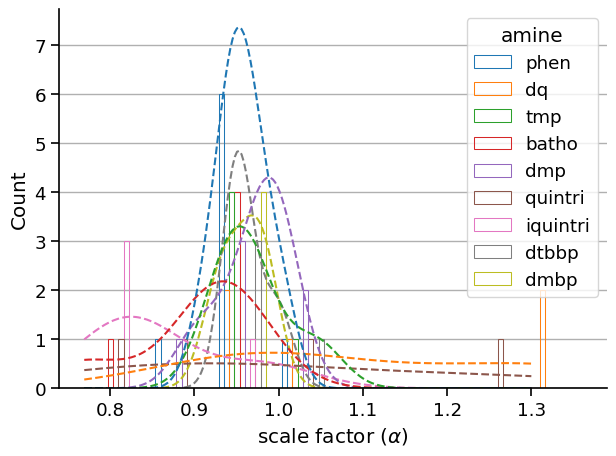

In [57]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = sns.color_palette("tab10")
# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=cuset.query("amine != 'other'"), x="shift_factor", hue="amine", multiple="dodge", 
                 shrink=.75, kde=True, binwidth=0.075, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
# g = sns.histplot(data=errors, x="shift_factor", hue="subset", multiple="dodge", shrink=.8, kde=True)
g.set_xlabel(r'scale factor ($\alpha$)')
# g.set_ylabel(None)
# g.set_ylim(0,18)
g.grid(axis = 'y')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('shift_distribution_B97D3_Cu-amines.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

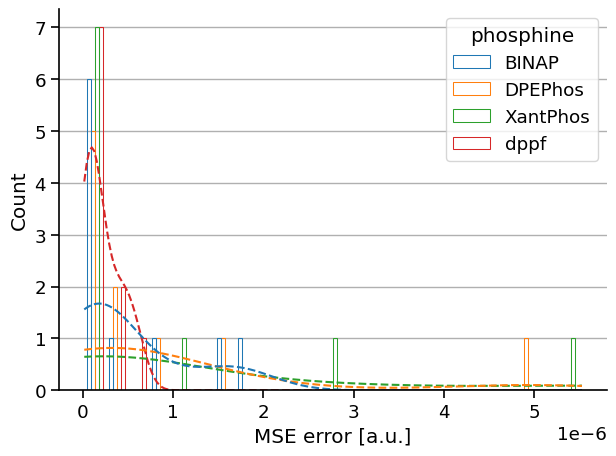

In [58]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = sns.color_palette("tab10")
# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=cuset.query("phosphine != 'other'"), x="error_value", hue="phosphine", multiple="dodge", 
                 shrink=.75, kde=True, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
# g = sns.histplot(data=errors, x="shift_factor", hue="subset", multiple="dodge", shrink=.8, kde=True)
g.set_xlabel("MSE error [a.u.]")
# g.set_ylabel(None)
# g.set_ylim(0,18)
g.grid(axis = 'y')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('error_distribution_B97D3_Cu-phosphines.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

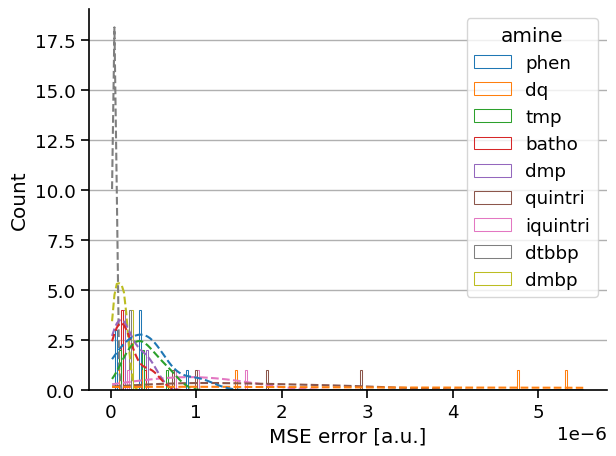

In [59]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = sns.color_palette("tab10")
# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=cuset.query("amine != 'other'"), x="error_value", hue="amine", multiple="dodge", 
                 shrink=.75, kde=True, fill=False, palette=palette, linewidth=0.75, line_kws={"lw":1.5,"ls":"--"})
# g = sns.histplot(data=errors, x="shift_factor", hue="subset", multiple="dodge", shrink=.8, kde=True)
g.set_xlabel("MSE error [a.u.]")
# g.set_ylabel(None)
# g.set_ylim(0,18)
g.grid(axis = 'y')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('error_distribution_B97D3_Cu-amines.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## Iron complexes with quintet and triplet ground states

In [60]:
db_1 = "_Fe_database_250nm.zip"
fulldb_1 = get_fulldb(db_1)
fulldb_1.drop(columns=["basis","error_function"], inplace=True) # only have def2SVP and MSE atm
expt = fulldb_1[fulldb_1['reference'] == 'yes']
expt = expt.drop(columns=["reference","functional","error_value","bandwidth","shift_factor"])

db_2 = "_Fe_Boltzmann_database_250nm.zip"
fulldb_2 = get_fulldb(db_2)
fulldb_2.drop(columns=["basis","error_function"], inplace=True) # only have def2SVP and MSE atm

In [61]:
mols = fulldb_2.molecule.unique()
funcs = ["M06","M06L"]
fdb_1_get = fulldb_1.query("reference == 'no'").query("molecule in @mols").query("functional in @funcs")
fulldb_2['functional'].replace({'M06':'M06_Boltzmann','M06L':'M06L_Boltzmann'},inplace=True)

merged_db = pd.concat([fdb_1_get,fulldb_2], ignore_index=True)

In [62]:
# merged_db.loc[merged_db["Wavelength [nm]"] == 400]

In [63]:
pred = merged_db[merged_db['reference'] == 'no']
errors = pred.drop(columns=["reference","Wavelength [nm]","Intensity [a.u.]"])
errors.drop_duplicates(inplace=True) # this is the computational database without the spectral data
errors = errors.astype({'error_value': 'float64','bandwidth': 'float64','shift_factor': 'float64'})

mse_order = errors.groupby("functional",as_index=False).mean(numeric_only=True).sort_values(by="error_value",ignore_index=True).functional.unique()

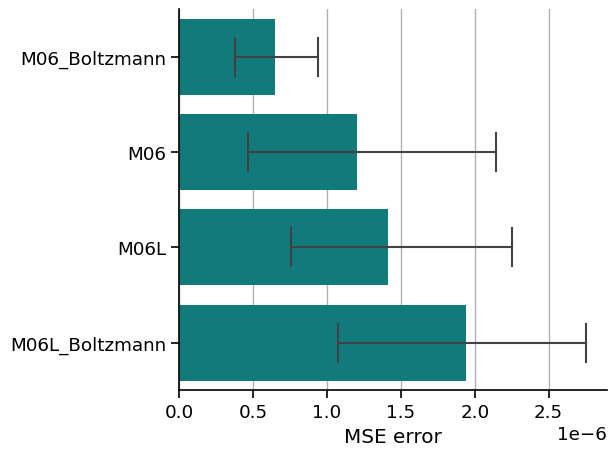

In [64]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

convert_error_names(errors)

# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.barplot(data=errors, x="error_value", y="functional", color="darkcyan", order=mse_order,
                capsize=.4, errwidth=1.5) # .set(xlabel=f'MSE error', ylabel=None)
g.set_xlabel('MSE error')
g.set_ylabel(None)
g.grid(axis = 'x')
g.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.savefig('Fe_boltzmann_errors.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

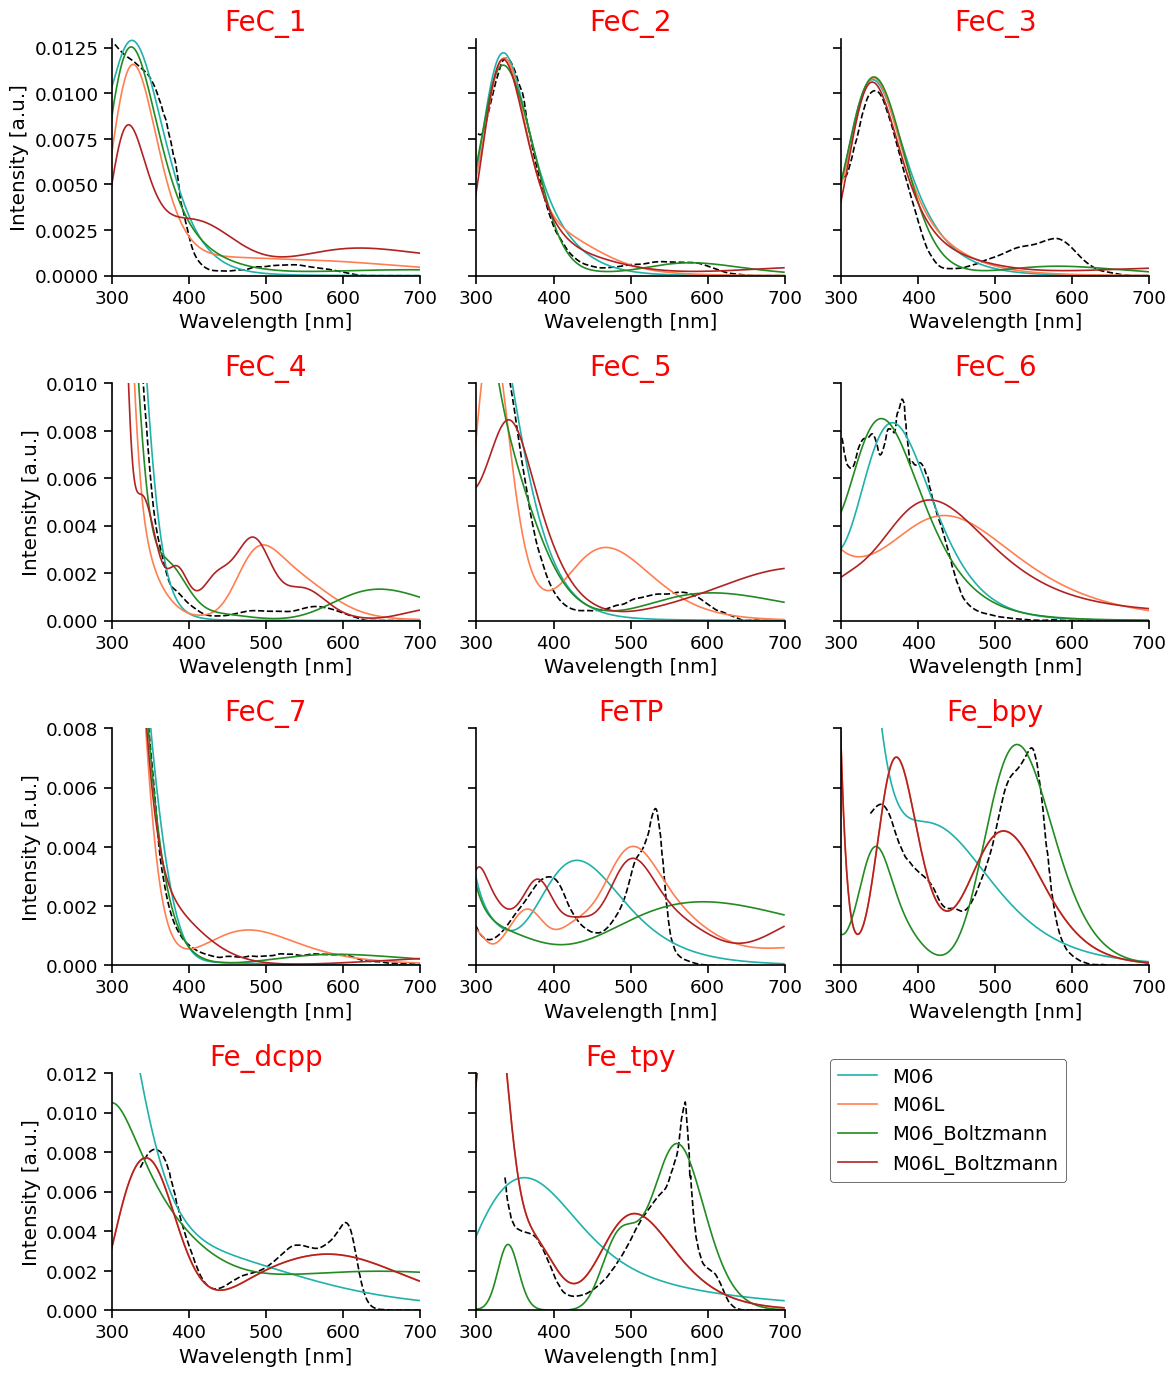

In [65]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,14), sharex="row", sharey="row")
flataxes = ax.flatten()
#fig.subplots_adjust(hspace=0.3)

# moleculesList = random.choices(merged_db.molecule.unique(),k=3)
func_order = ['M06','M06L','M06_Boltzmann','M06L_Boltzmann']
func_colors = ['lightseagreen','coral','forestgreen','firebrick']
moleculesList = sorted(merged_db.molecule.unique())
for i, mol in enumerate(moleculesList):
  subdb = merged_db.query("molecule == @mol")
  sns.lineplot(ax=flataxes[i],x="Wavelength [nm]", y="Intensity [a.u.]", data=subdb.query("reference == 'yes'"), color="black", linestyle='--')
  sns.lineplot(ax=flataxes[i],x="Wavelength [nm]", y="Intensity [a.u.]", data=subdb.query("reference == 'no'"), hue="functional",hue_order=func_order,palette=func_colors).legend(frameon=False,fontsize='12',ncol=1)
  # sns.lineplot(ax=flataxes[i],x="Wavelength [nm]", y="Intensity [a.u.]", data=subdb.query("reference == 'no'"), hue="functional",hue_order=func_order, legend=False)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  flataxes[i].set_title(title, color="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')

# ymax = 1.1*expt["Intensity [a.u.]"].max(numeric_only=True)
# ax[i][0].set_ylim(0,ymax)
# ax[i][0].set_xlim(200,700)

flataxes[0].set_ylim(0,0.013)
flataxes[3].set_ylim(0,0.010)
flataxes[6].set_ylim(0,0.008)
flataxes[9].set_ylim(0,0.012)

handles = flataxes[0].get_legend().legendHandles
labels = [i._text for i in flataxes[0].get_legend().texts]
# legend = fig.legend(handles=handles, labels=labels, loc='lower center', frameon=True, ncols=len(labels), 
#                     fontsize=14, bbox_to_anchor=(0.5, -0.035), edgecolor="k")
legend = fig.legend(handles=handles, labels=labels, loc='lower center', frameon=True, 
                    fontsize=14, bbox_to_anchor=(0.8, 0.14), edgecolor="k")
legend.get_frame().set_linewidth(0.5)
for i in range(len(flataxes)-1): # last subplot has no data and would give a nonetype error if legend is removed
  flataxes[i].get_legend().remove()
  if i in [0,3,6,9]:
    flataxes[i].set_xlim(300,700)

flataxes[-1].axis('off') # remove (hide) empty subplot
plt.tight_layout()
sns.despine()
plt.savefig('Fe_boltzmann_spectra.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [66]:
errors = get_errors_db(merged_db)

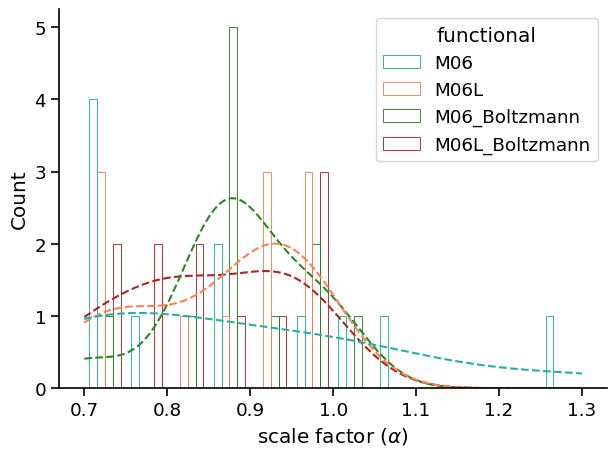

In [67]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

convert_error_names(errors)
func_order = ['M06','M06L','M06_Boltzmann','M06L_Boltzmann']
func_colors = ['lightseagreen','coral','forestgreen','firebrick']

# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.histplot(data=errors, x="shift_factor", hue="functional", hue_order=func_order, multiple="dodge", palette=func_colors,
                 shrink=.75, kde=True, binwidth=0.05, fill=False, linewidth=0.65, line_kws={"lw":1.5, "ls":"--"})

g.set_xlabel(r'scale factor ($\alpha$)')
sns.despine()
plt.tight_layout()
plt.savefig('Fe_Boltzmann_scalefactor_hist.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## Other isomers of Iridium

In [68]:
orig_db = get_fulldb("_Ir_database_250nm.zip")
isomer_db = get_fulldb("_Ir_isomers_250nm.zip")

# trans_replace_dict = {"Ir_isoCN_3":"Ir_isoCN_3_trans","Ir_isoCN_6":"Ir_isoCN_6_trans","Ir_isoCN_7":"Ir_isoCN_7_trans",
#                       "Ir_isoCN-acac_1":"Ir_isoCN-acac_1_trans","Ir_isoCN-acac_1":"Ir_isoCN-acac_1_trans","Ir_isoCN-acac_1":"Ir_isoCN-acac_1_trans"}
# cis_replace_dict = {"Ir_isoCN_3":"Ir_isoCN_3_cis","Ir_isoCN_6":"Ir_isoCN_6_cis","Ir_isoCN_7":"Ir_isoCN_7_cis",
#                     "Ir_isoCN-acac_1":"Ir_isoCN-acac_1_cis","Ir_isoCN-acac_1":"Ir_isoCN-acac_1_cis","Ir_isoCN-acac_1":"Ir_isoCN-acac_1_cis"}
# orig_db['molecule'].replace(trans_replace_dict,inplace=True)
# isomer_db['molecule'].replace(cis_replace_dict,inplace=True)

orig_db["isomer"] = "trans"
isomer_db["isomer"] = "cis"

In [69]:
mols_with_isomers = isomer_db.molecule.unique()
cistrans_db = pd.concat([orig_db.query("molecule in @mols_with_isomers"),isomer_db])

In [70]:
cistrans_errors = get_errors_db_isomers(cistrans_db)

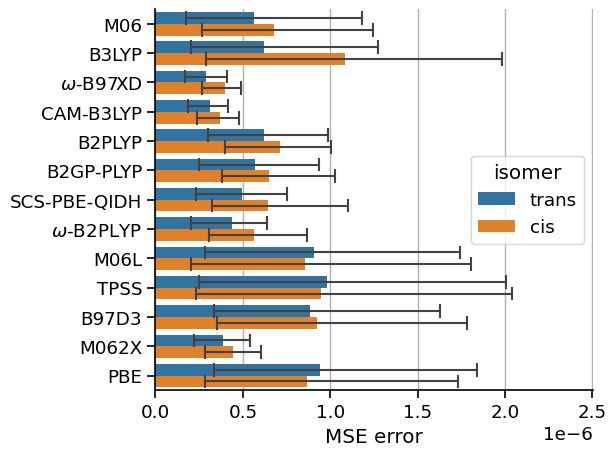

In [71]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

nofuncs = ['SOC-M06','SOC-M06L','SOC-$\\omega$-B97XD']
convert_error_names(cistrans_errors)

# errwidth, errcolor for sns.__version__ below 0.13, if above use err_kws
g = sns.barplot(data=cistrans_errors.query("functional not in @nofuncs"), x="error_value", y="functional", hue="isomer", order=mse_order_noSOC,
                capsize=.4, errwidth=1.5) # .set(xlabel=f'MSE error', ylabel=None)
g.set_xlabel('MSE error')
g.set_ylabel(None)
g.grid(axis = 'x')
g.set_axisbelow(True)
g.set_xlim(0,2.505e-6)
sns.despine()
plt.tight_layout()
plt.savefig('Ir_cistrans_errors.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [72]:
gen_spectra(cistrans_db.query("isomer == 'trans'"), mols_with_isomers, funcs=[func1,func2, func3], savename="Ir_trans.png")
gen_spectra(cistrans_db.query("isomer == 'cis'"), mols_with_isomers, funcs=[func1,func2, func3], savename="Ir_cis.png")

## def2TZVP vs def2SVP

In [73]:
tzvp_db = get_fulldb("def2TZVP_db.zip")
tzvpmols = tzvp_db.molecule.unique()
tzvpfuncts = tzvp_db.functional.unique()
svp_db = fulldb.query("molecule in @tzvpmols").query("functional in @tzvpfuncts").query("reference == 'no'").copy()

In [74]:
tzvp_db["basis"] = "def2-TZVP"
svp_db["basis"] = "def2-SVP"
basistest_db = pd.concat([svp_db,tzvp_db])

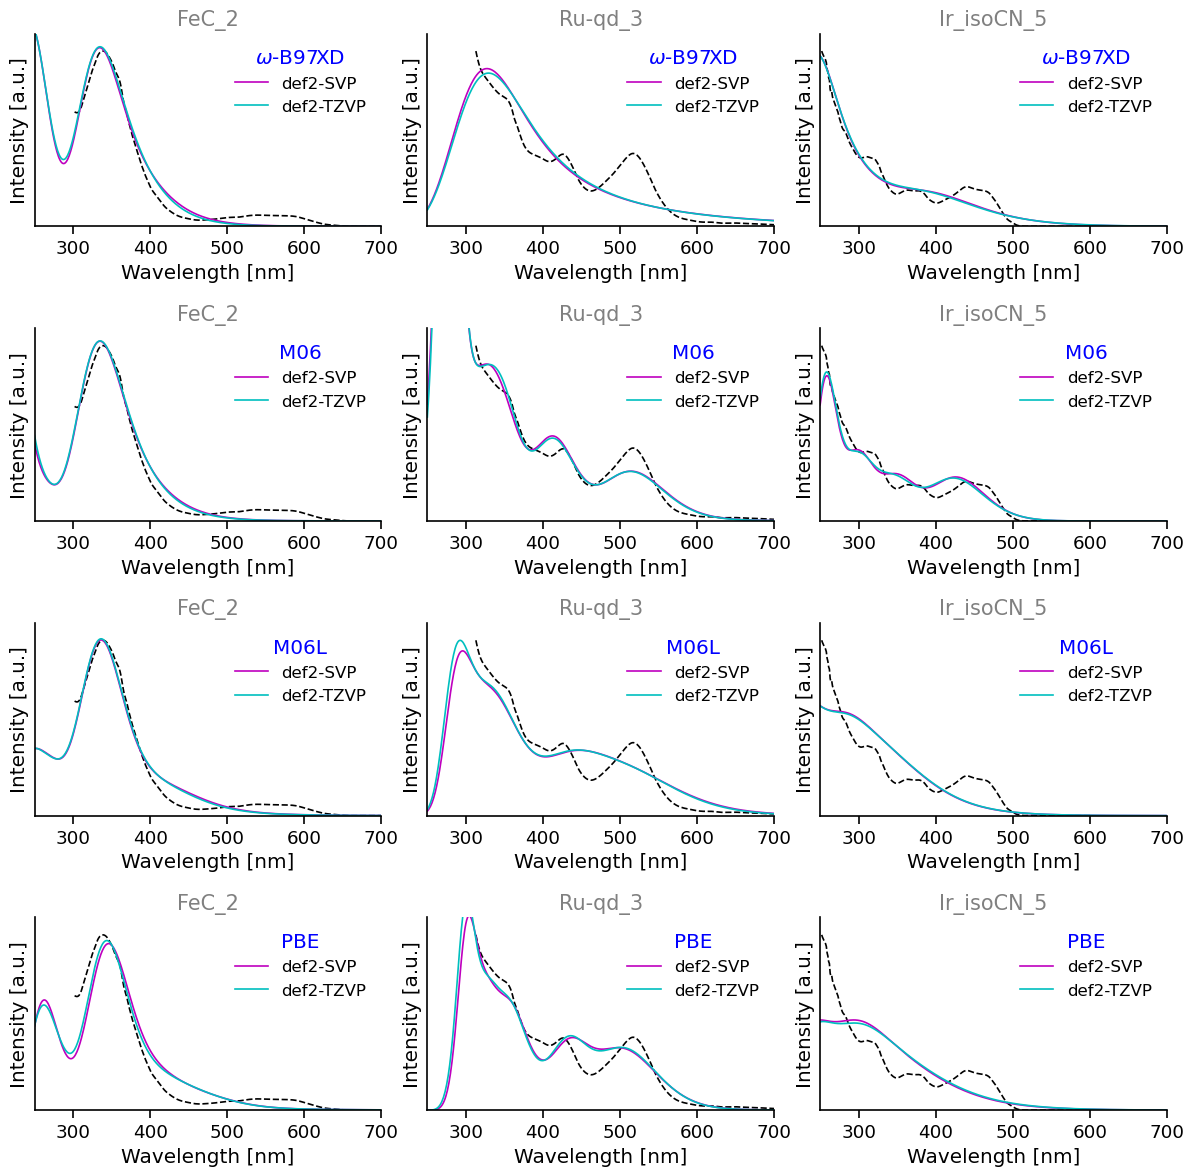

In [75]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), sharex="row") #, sharey="row")
#fig.subplots_adjust(hspace=0.3)

clrs = ["m","c"]
for i, func in enumerate(tzvpfuncts[:-1]): # last element is 'expt'
  basistest_db_calc = basistest_db.query("functional == @func")
  for j, mol in enumerate(tzvpmols):
    expt = basistest_db.query("reference == 'yes'").query("molecule == @mol")
    sns.lineplot(ax=ax[i][j],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
    sns.lineplot(ax=ax[i][j],x="Wavelength [nm]", y="Intensity [a.u.]", data=basistest_db_calc.query("molecule == @mol"), hue="basis", palette=clrs).legend(title=func,frameon=False,fontsize='12',ncol=1) # ,palette=pal,hue_order=func1
    ax[i][j].set_title(mol, color="grey", fontsize= 15)

    ymax = 1.1*expt["Intensity [a.u.]"].max(numeric_only=True)
    ax[i][j].set_ylim(0,ymax)
    ax[i][j].set_xlim(250,700)
    ax[i][j].yaxis.set_ticklabels([])
    ax[i][j].yaxis.set_ticks([])
    ax[i][j].get_legend().get_title().set_color('blue')

plt.tight_layout()
sns.despine()
plt.savefig('def2SVP_vs_def2TZVP.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [76]:
basistest_db.query("`Wavelength [nm]` == 400").query("reference == 'no'").get(["molecule","functional","basis","bandwidth","shift_factor"]).sort_values(by=["molecule","functional","basis"])

,molecule,functional,basis,bandwidth,shift_factor
10901,FeC_2,$\omega$-B97XD,def2-SVP,0.2976185032769395,1.0740131077579638
150,FeC_2,$\omega$-B97XD,def2-TZVP,0.3003746888177615,1.0671543971955495
11351,FeC_2,M06,def2-SVP,0.31266194177716816,0.8648376771833564
600,FeC_2,M06,def2-TZVP,0.31824544022760765,0.8589849108367628
7301,FeC_2,M06L,def2-SVP,0.2689897373367881,0.7465935070873343
1050,FeC_2,M06L,def2-TZVP,0.27295508814713204,0.7442463039170859
10001,FeC_2,PBE,def2-SVP,0.23475112947627302,0.700000564502927
1500,FeC_2,PBE,def2-TZVP,0.23856302957430833,0.700000564502927
180733,Ir_isoCN_5,$\omega$-B97XD,def2-SVP,0.4217001981405274,1.0258802011888433
4693,Ir_isoCN_5,$\omega$-B97XD,def2-TZVP,0.44591906721536356,1.0005486968449933


In [77]:
shift_bw_ordered = basistest_db.query("`Wavelength [nm]` == 400").query("reference == 'no'").get(["molecule","functional","basis","bandwidth","shift_factor"]).sort_values(by=["functional","molecule","basis"])
shift_bw_ordered.to_csv("shift_bw_ordered.csv",index=False)

In [78]:
plt.close()